# 1. Parameters

In [1]:
from pathlib import Path
from os import mkdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

simulation_root_dir = Path('simulations')

figures_path = Path('figures')
if not figures_path.exists():
    mkdir(figures_path)
    
min_cov = 10
sub_invariant = 0.3
reference_file = simulation_root_dir / 'reference' / 'reference.fa.gz'

simulation_cases = glob.glob(str(simulation_root_dir / 'cov*')) + glob.glob(str(simulation_root_dir / 'alpha*'))
simulation_cases = [Path(x) for x in simulation_cases]

# 2. Loading data

## 2.1. Counting substitutions between two most distant genomes

In [2]:
haplotypes_reads_paths = [x / 'simulated_data/haplotypes.vcf.gz' for x in simulation_cases]
haplotypes_reads_paths

[PosixPath('simulations/cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-20/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-5/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-40/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-50/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-10/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-5.0-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-0.1-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-10-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-0.05-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-0.5-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-2.0-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-1.0-cov-30/simulated_data/haplotypes.vcf.gz')]

In [3]:
from genomics_data_index.storage.io.mutation.SequenceFile import SequenceFile

reference_name, records = SequenceFile(reference_file).parse_sequence_file()
reference_length = 0
for record in records:
    reference_length = reference_length + len(record)
reference_length

19699

In [4]:
import vcf
from typing import Dict, List, Tuple

sample1 = 'reference'
sample2 = 'SH14-012'

def observed_differences(file: Path, sample1: str, sample2: str) -> Tuple[int, int]:
    reader = vcf.Reader(filename=str(file))
    df = pd.DataFrame([vars(r) for r in reader])
    df['samples_map'] = df['samples'].apply(lambda x: {s.sample: s for s in x})
    df_no_indel = df[~df['samples'].apply(lambda x: x[0].site.is_indel)]
    df_indel = df[df['samples'].apply(lambda x: x[0].site.is_indel)]
    
    number_no_indel = df_no_indel['samples_map'].apply(lambda x: x[sample1].data.GT != x[sample2].data.GT).value_counts()[True]
    all_simulated_mutations = len(df)
    
    return number_no_indel, all_simulated_mutations

def all_observed_diffs(files: List[Path], sample1: str, sample2: str) -> List[int]:
    all_results = [observed_differences(file=x, sample1=sample1, sample2=sample2) for x in files]
    substitution_differences = [x for x,y in all_results]
    all_simulated_mutations = [y for x,y in all_results]
        
    return {
        'Paths': list(map(str, files)),
        'Largest observed substitution difference': substitution_differences,
        'All simulated mutations': all_simulated_mutations,
    }

simulation_mutations = all_observed_diffs(haplotypes_reads_paths, sample1=sample1, sample2=sample2)

In [5]:
obs_subs_df = pd.DataFrame(simulation_mutations)
obs_subs_df['Alpha'] = obs_subs_df['Paths'].str.extract(r'alpha-([^-]+)-').astype(float)
obs_subs_df.loc[obs_subs_df['Paths'].str.contains('/cov-'), 'Alpha'] = 0.2
obs_subs_df['Proportion invariant'] = sub_invariant
obs_subs_df['Reference length bp'] = reference_length
obs_subs_df['Largest substitution divergence'] = obs_subs_df['Largest observed substitution difference'] \
    / obs_subs_df['Reference length bp']
obs_subs_df.loc[:, 'Name of case'] = obs_subs_df['Paths'].str.extract(r'/([^/]+)/simulated_data')
obs_subs_df = obs_subs_df.sort_values('Largest substitution divergence')
obs_subs_df

,Paths,Largest observed substitution difference,All simulated mutations,Alpha,Proportion invariant,Reference length bp,Largest substitution divergence,Name of case
9,simulations/alpha-0.05-cov-30/simulated_data/h...,310,885,0.05,0.3,19699,0.015737,alpha-0.05-cov-30
7,simulations/alpha-0.1-cov-30/simulated_data/ha...,371,1048,0.10,0.3,19699,0.018833,alpha-0.1-cov-30
0,simulations/cov-30/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-30
1,simulations/cov-20/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-20
2,simulations/cov-5/simulated_data/haplotypes.vc...,473,1357,0.20,0.3,19699,0.024011,cov-5
3,simulations/cov-40/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-40
4,simulations/cov-50/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-50
5,simulations/cov-10/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-10
10,simulations/alpha-0.5-cov-30/simulated_data/ha...,827,2221,0.50,0.3,19699,0.041982,alpha-0.5-cov-30
12,simulations/alpha-1.0-cov-30/simulated_data/ha...,1333,3410,1.00,0.3,19699,0.067668,alpha-1.0-cov-30


In [6]:
obs_subs_df.loc[:, 'Type of case'] = 'reads'
obs_subs_assemblies = obs_subs_df.copy()
obs_subs_assemblies.loc[:, 'Type of case'] = 'assemblies'
obs_subs_reads_assemblies = obs_subs_df.copy()
obs_subs_reads_assemblies.loc[:, 'Type of case'] = 'reads-to-assemblies'
obs_subs_df = pd.concat([obs_subs_df, obs_subs_assemblies, obs_subs_reads_assemblies])
obs_subs_df.loc[:, 'Name with type'] = obs_subs_df['Name of case'] + ' ' + obs_subs_df['Type of case']
obs_subs_df = obs_subs_df[['Name of case', 'Name with type', 'Largest observed substitution difference',
                           'Largest substitution divergence',
                          'Reference length bp']]
obs_subs_df

,Name of case,Name with type,Largest observed substitution difference,Largest substitution divergence,Reference length bp
9,alpha-0.05-cov-30,alpha-0.05-cov-30 reads,310,0.015737,19699
7,alpha-0.1-cov-30,alpha-0.1-cov-30 reads,371,0.018833,19699
0,cov-30,cov-30 reads,473,0.024011,19699
1,cov-20,cov-20 reads,473,0.024011,19699
2,cov-5,cov-5 reads,473,0.024011,19699
3,cov-40,cov-40 reads,473,0.024011,19699
4,cov-50,cov-50 reads,473,0.024011,19699
5,cov-10,cov-10 reads,473,0.024011,19699
10,alpha-0.5-cov-30,alpha-0.5-cov-30 reads,827,0.041982,19699
12,alpha-1.0-cov-30,alpha-1.0-cov-30 reads,1333,0.067668,19699


## 2.2. Loading index information

In [7]:
from typing import List

index_info_reads_paths = [x / 'reads-index-info.tsv' for x in simulation_cases]
index_info_reads_paths = [x for x in index_info_reads_paths if x.exists()]

index_info_assemblies_paths = [x / 'assemblies-index-info.tsv' for x in simulation_cases]
index_info_assemblies_paths = [x for x in index_info_assemblies_paths if x.exists()]

index_info_reads_assemblies_paths = [x / 'assemblies-reads-index-info.tsv' for x in simulation_cases]
index_info_reads_assemblies_paths = [x for x in index_info_reads_assemblies_paths if x.exists()]

def read_all_df(df_paths: List[Path], name_col: str = 'Name', override_type: bool = True) -> pd.DataFrame:
    dfs = []
    for df_path in df_paths:
        dfs.append(pd.read_csv(df_path, sep='\t'))
        
    dfs_concat = pd.concat(dfs).reset_index(drop=True)
        
    if override_type:
        dfs_concat['Type'] = dfs_concat[name_col].str.extract(r'^\S+ (\S+)')
    dfs_concat['Coverage'] = dfs_concat[name_col].str.extract(r'cov-(\d+)').astype(int)
    dfs_concat['Alpha'] = dfs_concat[name_col].str.extract(r'alpha-([^-]+)-').astype(float)
    dfs_concat.loc[dfs_concat[name_col].str.match(r'^cov'), 'Alpha'] = 0.2
        
    return dfs_concat

index_info_df = read_all_df(index_info_reads_paths + index_info_assemblies_paths + index_info_reads_assemblies_paths)
index_info_reads_assemblies_df = read_all_df(index_info_reads_assemblies_paths)
index_info_df.head(5)

,Name,Reference name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),...,Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Type,Coverage,Alpha
0,cov-30 reads,reference,1,60,3488,1385,32,19699,114.95,3.383751e+09,...,3.071918e+08,2162688.0,10.41,286846976.0,251371520.0,133.71,6.204375e+09,reads,30,0.2
1,cov-20 reads,reference,1,60,9861,1360,32,19699,117.59,3.347018e+09,...,3.361710e+08,2596864.0,10.55,299614208.0,251244544.0,138.10,6.224196e+09,reads,20,0.2
2,cov-5 reads,reference,1,60,19989,290,32,19699,130.27,3.353211e+09,...,1.342067e+09,3391488.0,18.89,319168512.0,251654144.0,182.84,6.583325e+09,reads,5,0.2
3,cov-40 reads,reference,1,60,2940,1393,32,19699,119.18,3.117457e+09,...,2.983977e+08,2105344.0,10.96,284803072.0,251408384.0,137.82,6.204473e+09,reads,40,0.2
4,cov-50 reads,reference,1,60,2393,1398,32,19699,117.18,3.231146e+09,...,2.974556e+08,2060288.0,10.31,283373568.0,251600896.0,135.29,6.198886e+09,reads,50,0.2


# 5. Features comparison

In [8]:
obs_subs_df

,Name of case,Name with type,Largest observed substitution difference,Largest substitution divergence,Reference length bp
9,alpha-0.05-cov-30,alpha-0.05-cov-30 reads,310,0.015737,19699
7,alpha-0.1-cov-30,alpha-0.1-cov-30 reads,371,0.018833,19699
0,cov-30,cov-30 reads,473,0.024011,19699
1,cov-20,cov-20 reads,473,0.024011,19699
2,cov-5,cov-5 reads,473,0.024011,19699
3,cov-40,cov-40 reads,473,0.024011,19699
4,cov-50,cov-50 reads,473,0.024011,19699
5,cov-10,cov-10 reads,473,0.024011,19699
10,alpha-0.5-cov-30,alpha-0.5-cov-30 reads,827,0.041982,19699
12,alpha-1.0-cov-30,alpha-1.0-cov-30 reads,1333,0.067668,19699


In [9]:
features_paths = [x / 'variants-comparison.tsv' for x in simulation_cases]
features_paths = [x for x in features_paths if x.exists()]

features_df = read_all_df(features_paths)

features_df = features_df.merge(obs_subs_df, left_on='Name',
                              right_on='Name with type',
                              how='inner')

features_count_df = pd.melt(features_df, id_vars=['Type', 'Coverage', 'Alpha',
                                                  'Largest substitution divergence'],
        value_vars=['True Positives', 'False Positives', 'False Negatives'])
features_count_df = features_count_df.rename({'value': 'Count'}, axis='columns')

features_score_df = pd.melt(features_df, id_vars=['Type', 'Coverage', 'Alpha',
                                                 'Largest substitution divergence'],
                            value_vars=['Sensitivity', 'Precision', 'F1 Score'])
features_score_df = features_score_df.rename({'value': 'Score'}, axis='columns')
features_count_df

,Type,Coverage,Alpha,Largest substitution divergence,variable,Count
0,reads,30,0.2,0.024011,True Positives,14851
1,assemblies,30,0.2,0.024011,True Positives,16838
2,reads-to-assemblies,30,0.2,0.024011,True Positives,16428
3,reads,20,0.2,0.024011,True Positives,14401
4,assemblies,20,0.2,0.024011,True Positives,16838
...,...,...,...,...,...,...
103,assemblies,30,2.0,0.104015,False Negatives,83153
104,reads-to-assemblies,30,2.0,0.104015,False Negatives,83525
105,reads,30,1.0,0.067668,False Negatives,17629
106,assemblies,30,1.0,0.067668,False Negatives,2488


In [10]:
features_score_df

,Type,Coverage,Alpha,Largest substitution divergence,variable,Score
0,reads,30,0.2,0.024011,Sensitivity,0.877097
1,assemblies,30,0.2,0.024011,Sensitivity,0.994448
2,reads-to-assemblies,30,0.2,0.024011,Sensitivity,0.970234
3,reads,20,0.2,0.024011,Sensitivity,0.850520
4,assemblies,20,0.2,0.024011,Sensitivity,0.994448
...,...,...,...,...,...,...
103,assemblies,30,2.0,0.104015,F1 Score,0.040679
104,reads-to-assemblies,30,2.0,0.104015,F1 Score,0.032100
105,reads,30,1.0,0.067668,F1 Score,0.734694
106,assemblies,30,1.0,0.067668,F1 Score,0.975611


In [11]:
markers_data_type = ['o', 's', '^']
palette_data_type = ['#1b9e77', '#d95f02', '#7570b3']

In [12]:
plot_transition_scale = features_count_df[(features_count_df['Coverage'] == 30) & 
                  (features_count_df['Type'] == 'reads') & 
                  (features_count_df['variable'] == 'True Positives')]
plot_transition_scale = plot_transition_scale.rename({'Alpha': 'Transition rate'}, axis='columns')
plot_transition_scale = plot_transition_scale.sort_values('Transition rate')
plot_transition_scale

,Type,Coverage,Transition rate,Largest substitution divergence,variable,Count
24,reads,30,0.05,0.015737,True Positives,9859
21,reads,30,0.10,0.018833,True Positives,11905
0,reads,30,0.20,0.024011,True Positives,14851
27,reads,30,0.50,0.041982,True Positives,24199
33,reads,30,1.00,0.067668,True Positives,34621
30,reads,30,2.00,0.104015,True Positives,44054
18,reads,30,5.00,0.176709,True Positives,31570


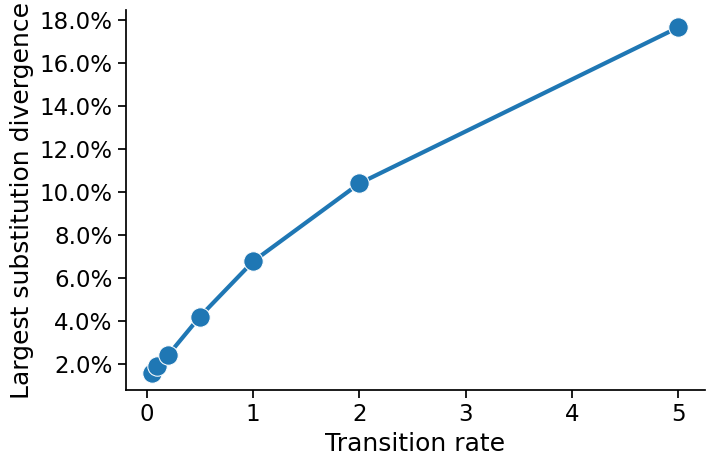

In [13]:
import matplotlib.ticker as mtick

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Transition rate', y='Largest substitution divergence', style="Type", hue="Type", kind="line",
                    data=plot_transition_scale, estimator='mean',
                    height=5, aspect=1.5, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=['o'],
                    facet_kws={'sharey': False, 'sharex': True})
    g._legend.remove()
    
    for idx, ax in enumerate(g.axes.flat):
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        
    plt.savefig('figures/largest-substitution-divergence.pdf')

## 5.1. Comparison of true negative/positive counts

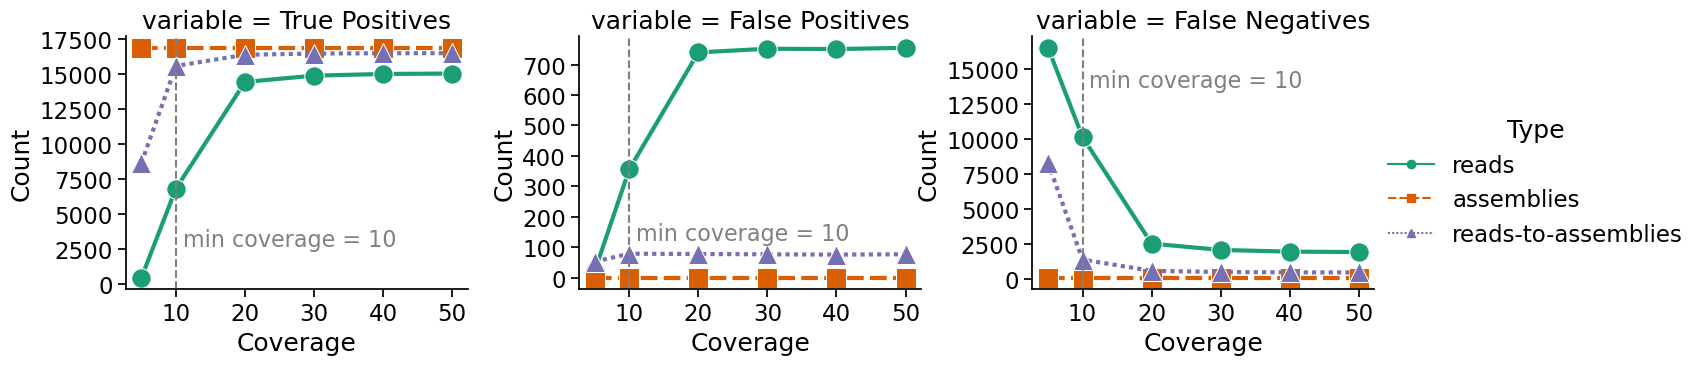

In [14]:
features_count_coverage_df = features_count_df[features_count_df['Alpha'] == 0.2]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Coverage', y='Count', hue="Type", style="Type", errorbar="sd", kind="line",
                    data=features_count_coverage_df, col="variable", estimator='mean',
                    height=4, aspect=1.2, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=markers_data_type,
                    palette=palette_data_type,
                    facet_kws={'sharey': False, 'sharex': True})
    
    for idx, ax in enumerate(g.axes.flat):
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        if idx == 2:
            ypos = ylim[1] - ylen * 0.2
        else:
            ypos = ylen * 0.15
        ax.text(min_cov + 1, ypos, f'min coverage = {min_cov}', fontdict={'size': 16, 'color': 'gray'})
        
    plt.savefig('figures/features-coverage-counts.pdf')

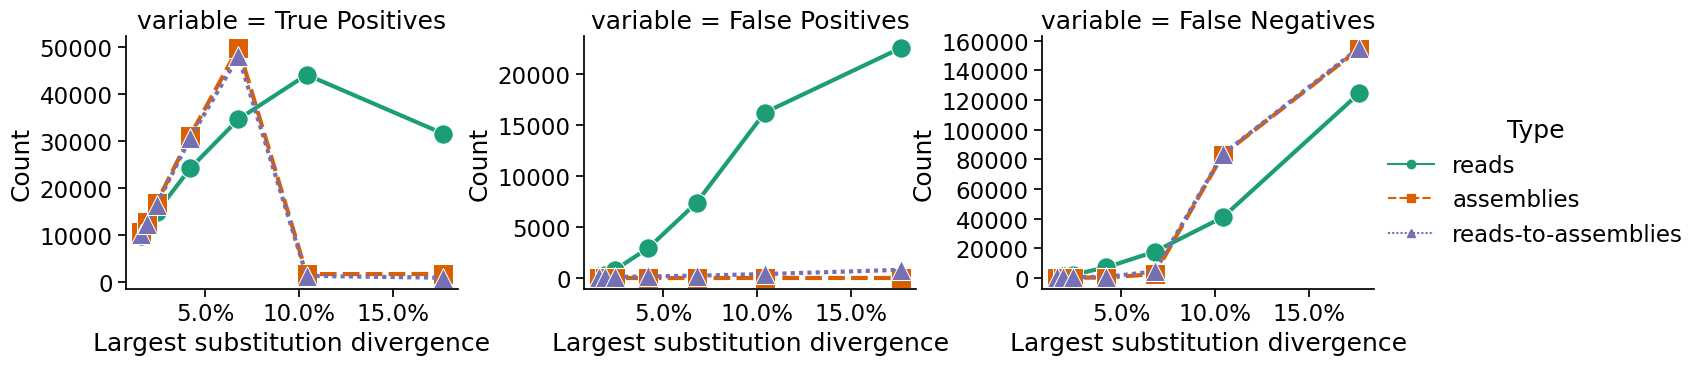

In [15]:
features_count_alpha_df = features_count_df[features_count_df['Coverage'] == 30]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Largest substitution divergence', y='Count', hue="Type", style="Type", errorbar="sd", kind="line",
                    data=features_count_alpha_df, col="variable", estimator='mean',
                    height=4, aspect=1.2, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=markers_data_type,
                    palette=palette_data_type,
                    facet_kws={'sharey': False, 'sharex': True})
    
    for idx, ax in enumerate(g.axes.flat):
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    plt.savefig('figures/features-alpha-counts.pdf')

## 5.2. Comparison of scores

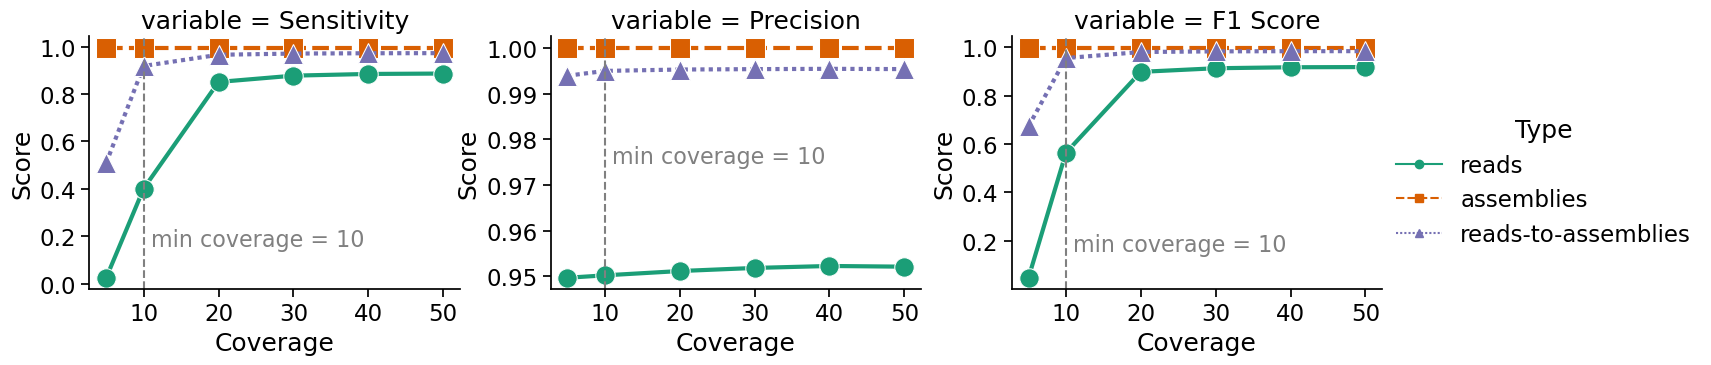

In [16]:
features_score_coverage_df = features_score_df[features_score_df['Alpha'] == 0.2]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Coverage', y='Score', hue="Type", style="Type", errorbar="sd", kind="line",
                    data=features_score_coverage_df, col="variable", estimator='mean',
                    height=4, aspect=1.2, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=markers_data_type,
                    palette=palette_data_type,
                    facet_kws={'sharey': False, 'sharex': True})
    
    for idx, ax in enumerate(g.axes.flat):
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        if idx == 1:
            ypos = ylim[1] - ylen * 0.5
        else:
            ypos = ylen * 0.15
        ax.text(min_cov + 1, ypos, f'min coverage = {min_cov}', fontdict={'size': 16, 'color': 'gray'})
        
    plt.savefig('figures/features-coverage-scores.pdf')

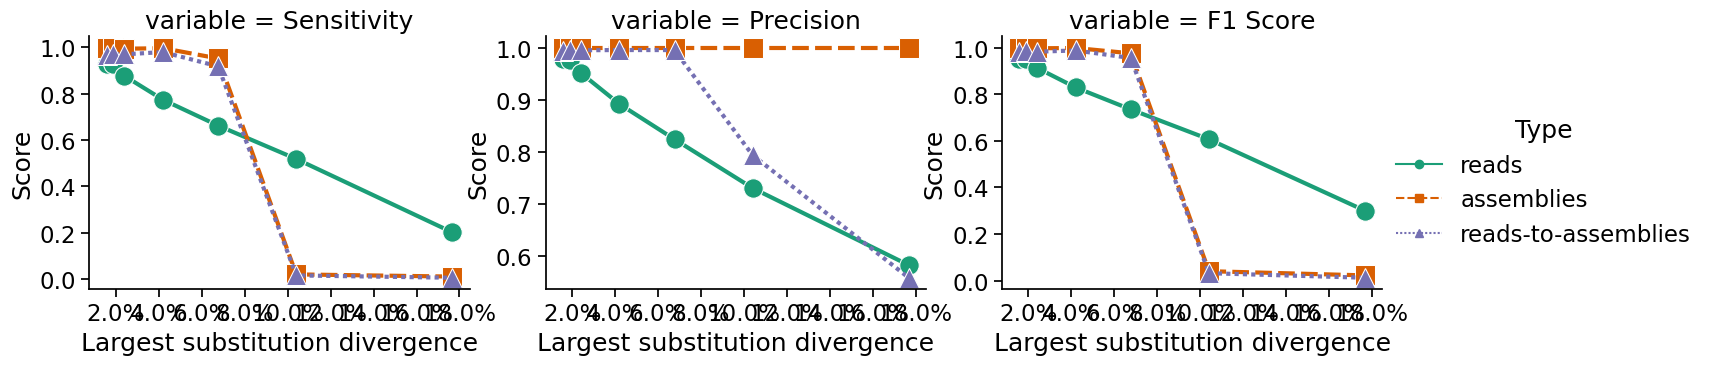

In [17]:
features_score_alpha_df = features_score_df[features_score_df['Coverage'] == 30]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Largest substitution divergence', y='Score', hue="Type", style="Type", errorbar="sd", kind="line",
                    data=features_score_alpha_df, col="variable", estimator='mean',
                    height=4, aspect=1.2, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=markers_data_type,
                    palette=palette_data_type,
                    facet_kws={'sharey': False, 'sharex': True})
    
    for idx, ax in enumerate(g.axes.flat):
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    plt.savefig('figures/features-alpha-scores.pdf')

## 5.3. Counts

### 5.3.1. TP

In [18]:
features_count_df[features_count_df['variable'] == 'True Positives'].sort_values(['Type', 'Count'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Count
31,assemblies,30,2.00,0.104015,True Positives,1763
19,assemblies,30,5.00,0.176709,True Positives,1789
25,assemblies,30,0.05,0.015737,True Positives,10606
22,assemblies,30,0.10,0.018833,True Positives,12818
1,assemblies,30,0.20,0.024011,True Positives,16838
4,assemblies,20,0.20,0.024011,True Positives,16838
7,assemblies,5,0.20,0.024011,True Positives,16838
10,assemblies,40,0.20,0.024011,True Positives,16838
13,assemblies,50,0.20,0.024011,True Positives,16838
16,assemblies,10,0.20,0.024011,True Positives,16838


### 5.3.2. FP

In [19]:
features_count_df[features_count_df['variable'] == 'False Positives'].sort_values(['Type', 'Count'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Count
37,assemblies,30,0.20,0.024011,False Positives,0
40,assemblies,20,0.20,0.024011,False Positives,0
43,assemblies,5,0.20,0.024011,False Positives,0
46,assemblies,40,0.20,0.024011,False Positives,0
49,assemblies,50,0.20,0.024011,False Positives,0
52,assemblies,10,0.20,0.024011,False Positives,0
55,assemblies,30,5.00,0.176709,False Positives,0
58,assemblies,30,0.10,0.018833,False Positives,0
61,assemblies,30,0.05,0.015737,False Positives,0
64,assemblies,30,0.50,0.041982,False Positives,0


### 5.3.3. FN

In [20]:
features_count_df[features_count_df['variable'] == 'False Negatives'].sort_values(['Type', 'Count'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Count
94,assemblies,30,0.10,0.018833,False Negatives,23
97,assemblies,30,0.05,0.015737,False Negatives,23
73,assemblies,30,0.20,0.024011,False Negatives,94
76,assemblies,20,0.20,0.024011,False Negatives,94
79,assemblies,5,0.20,0.024011,False Negatives,94
82,assemblies,40,0.20,0.024011,False Negatives,94
85,assemblies,50,0.20,0.024011,False Negatives,94
88,assemblies,10,0.20,0.024011,False Negatives,94
100,assemblies,30,0.50,0.041982,False Negatives,107
106,assemblies,30,1.00,0.067668,False Negatives,2488


### 5.3.4. Sensitivity

In [21]:
features_score_df[features_score_df['variable'] == 'Sensitivity'].sort_values(['Type', 'Score'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Score
19,assemblies,30,5.00,0.176709,Sensitivity,0.011451
31,assemblies,30,2.00,0.104015,Sensitivity,0.020762
34,assemblies,30,1.00,0.067668,Sensitivity,0.952383
1,assemblies,30,0.20,0.024011,Sensitivity,0.994448
4,assemblies,20,0.20,0.024011,Sensitivity,0.994448
7,assemblies,5,0.20,0.024011,Sensitivity,0.994448
10,assemblies,40,0.20,0.024011,Sensitivity,0.994448
13,assemblies,50,0.20,0.024011,Sensitivity,0.994448
16,assemblies,10,0.20,0.024011,Sensitivity,0.994448
28,assemblies,30,0.50,0.041982,Sensitivity,0.996577


### 5.3.5. Precision

In [22]:
features_score_df[features_score_df['variable'] == 'Precision'].sort_values(['Type', 'Score'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Score
37,assemblies,30,0.20,0.024011,Precision,1.000000
40,assemblies,20,0.20,0.024011,Precision,1.000000
43,assemblies,5,0.20,0.024011,Precision,1.000000
46,assemblies,40,0.20,0.024011,Precision,1.000000
49,assemblies,50,0.20,0.024011,Precision,1.000000
52,assemblies,10,0.20,0.024011,Precision,1.000000
55,assemblies,30,5.00,0.176709,Precision,1.000000
58,assemblies,30,0.10,0.018833,Precision,1.000000
61,assemblies,30,0.05,0.015737,Precision,1.000000
64,assemblies,30,0.50,0.041982,Precision,1.000000


### 5.3.6. F1 Score

In [23]:
features_score_df[features_score_df['variable'] == 'F1 Score'].sort_values(['Type', 'Score'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Score
91,assemblies,30,5.00,0.176709,F1 Score,0.022643
103,assemblies,30,2.00,0.104015,F1 Score,0.040679
106,assemblies,30,1.00,0.067668,F1 Score,0.975611
73,assemblies,30,0.20,0.024011,F1 Score,0.997216
76,assemblies,20,0.20,0.024011,F1 Score,0.997216
79,assemblies,5,0.20,0.024011,F1 Score,0.997216
82,assemblies,40,0.20,0.024011,F1 Score,0.997216
85,assemblies,50,0.20,0.024011,F1 Score,0.997216
88,assemblies,10,0.20,0.024011,F1 Score,0.997216
100,assemblies,30,0.50,0.041982,F1 Score,0.998286


# 6. Compare trees

## 6.1. Loading trees

In [24]:
trees_file = simulation_root_dir / 'tree-comparisons.tsv'

trees_df = read_all_df([trees_file], name_col='Simulation', override_type=False)
trees_df.loc[:, 'Simulation with type'] = trees_df['Simulation'] + ' ' + trees_df['Type']

trees_df = trees_df.merge(obs_subs_df, left_on='Simulation with type',
                              right_on='Name with type',
                              how='inner')

trees_df = pd.melt(trees_df, id_vars=['Type', 'Coverage', 'Alpha', 'Largest substitution divergence'],
        value_vars=['RFN_Distance', 'KC_Distance']).rename({'variable': 'Measure', 'value': 'Distance'}, 
                                                          axis='columns')
trees_df['Measure'] = trees_df['Measure'].str.replace('RFN_Distance', 'Normalized Robinson-Foulds')
trees_df['Measure'] = trees_df['Measure'].str.replace('KC_Distance', 'Kendall-Colijn')


# I ran assemblies multiple times for each coverage even though I only need one value so 
# I just pick one of the distances and set everything else to it
# I pick the distances that give me the maximum Robinson-Foulds score for alpha == 0.2
trees_tmp_df = trees_df[(trees_df['Alpha'] == 0.2) \
                        & (trees_df['Type'] == 'assemblies') \
                        & (trees_df['Measure'] == 'Normalized Robinson-Foulds')]
max_coverage_for_distance = trees_tmp_df.sort_values('Distance', ascending=False).iloc[0]['Coverage']
print(f'Assemblies case max coverage used for distances: {max_coverage_for_distance}')

# Now find distances for max
assemblies_rf_distance = trees_df[(trees_df['Coverage'] == max_coverage_for_distance) 
                                 & (trees_df['Type'] == 'assemblies')
                                 & (trees_df['Measure'] == 'Normalized Robinson-Foulds')]['Distance'].values[0]
assemblies_kc_distance = trees_df[(trees_df['Coverage'] == max_coverage_for_distance)
                                 & (trees_df['Type'] == 'assemblies')
                                 & (trees_df['Measure'] == 'Kendall-Colijn')]['Distance'].values[0]
number_trials_assemblies = len(trees_tmp_df)

trees_df['Type'] = trees_df['Type'].astype(pd.CategoricalDtype(
                        categories=['reads', 'assemblies', 'reads-to-assemblies'], 
                        ordered=True))
trees_df = trees_df.sort_values(['Type', 'Measure'], ascending=[True,False])

trees_df

Assemblies case max coverage used for distances: 10


,Type,Coverage,Alpha,Largest substitution divergence,Measure,Distance
0,reads,30,0.05,0.015737,Normalized Robinson-Foulds,0.741379
1,reads,30,0.10,0.018833,Normalized Robinson-Foulds,0.758621
2,reads,30,0.50,0.041982,Normalized Robinson-Foulds,0.724138
3,reads,30,1.00,0.067668,Normalized Robinson-Foulds,0.741379
4,reads,30,2.00,0.104015,Normalized Robinson-Foulds,0.758621
5,reads,30,5.00,0.176709,Normalized Robinson-Foulds,0.775862
6,reads,10,0.20,0.024011,Normalized Robinson-Foulds,0.793103
7,reads,20,0.20,0.024011,Normalized Robinson-Foulds,0.724138
8,reads,30,0.20,0.024011,Normalized Robinson-Foulds,0.741379
9,reads,40,0.20,0.024011,Normalized Robinson-Foulds,0.741379


## 6.2. Compare reads vs. assembly (coverage)

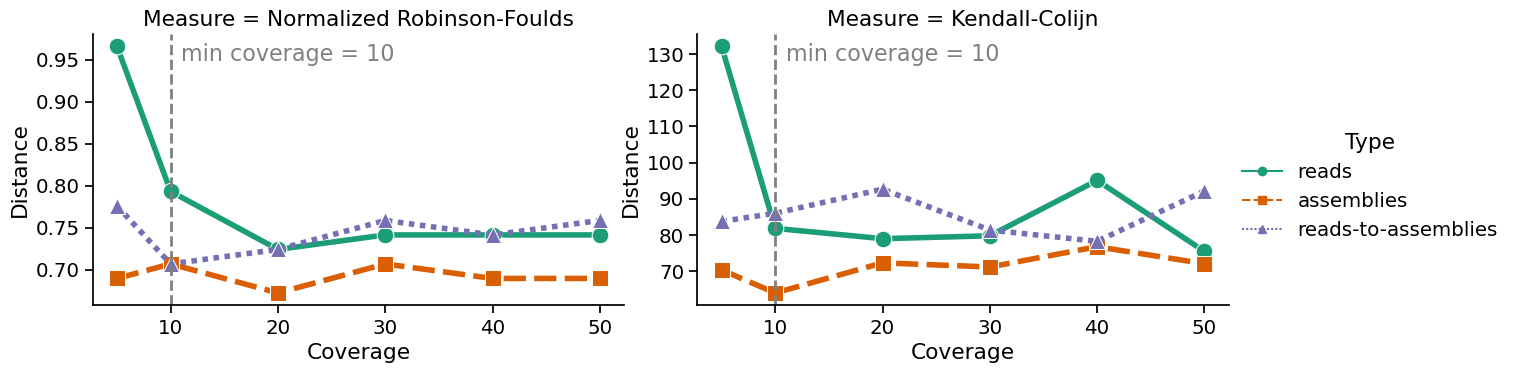

In [25]:
# trees_coverage_df = trees_df[(trees_df['Alpha'] == 0.2) & (trees_df['Type'].isin(['reads', 'reads-to-assemblies']))]
trees_coverage_df = trees_df[(trees_df['Alpha'] == 0.2)]

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(
        data=trees_coverage_df, kind="line", col="Measure",
        x="Coverage", y="Distance", hue="Type", style="Type",
        markers=markers_data_type,
        palette=palette_data_type,
        linewidth=4, markersize=12,
        alpha=1.0, height=4, aspect=1.6,
        facet_kws={'sharey': False, 'sharex': True},
        legend=True,
    )
    
    for ax in g.axes.flat:
#         if ax.title.get_text() == "Measure = Normalized Robinson-Foulds":
#             ax.axhline(assemblies_rf_distance, color='#ff7f0e', ls='--', lw=4)
#         elif ax.title.get_text() == "Measure = Kendall-Colijn":
#             ax.axhline(assemblies_kc_distance, color='#ff7f0e', ls='--', lw=4)
        
        ax.axvline(min_cov, color='gray', ls='--', lw=2)
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.1
        ax.text(min_cov + 1, ypos, f'min coverage = {min_cov}', fontdict={'size': 16, 'color': 'gray'})
        
    # plt.legend(bbox_to_anchor=(1, 0.8), frameon=False,
    #            title='Type', loc='upper left',
    #            labels=['reads', 'reads-to-assemblies', f'assembly\n(max NRF over {number_trials_assemblies} trials)'])
    # plt.legend(bbox_to_anchor=(1, 0.8), frameon=False,
    #            title='Type', loc='upper left',
    #            labels=['reads', 'reads-to-assemblies', f'assemblies'])
    # plt.tight_layout()
    plt.savefig('figures/tree-coverages.pdf')

## 6.3. Reads vs assembly (alpha)

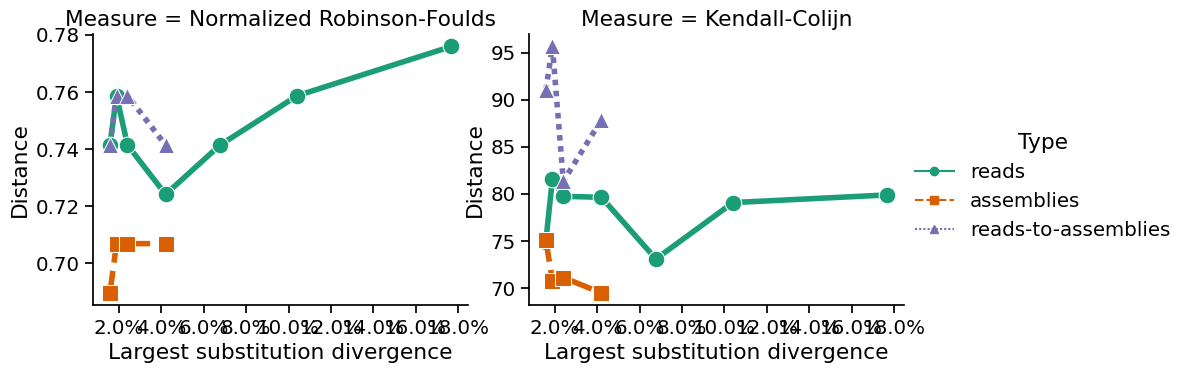

In [26]:
trees_alpha_df = trees_df[trees_df['Coverage'] == 30]
trees_alpha_df

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(
        data=trees_alpha_df, kind="line", col="Measure",
        x="Largest substitution divergence", y="Distance", hue="Type", style="Type",
        markers=markers_data_type,
        palette=palette_data_type,
        linewidth=4, markersize=12,
        alpha=1.0, height=4, aspect=1.2,
        facet_kws={'sharey': False, 'sharex': True}
    )
    
    for idx, ax in enumerate(g.axes.flat):
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    plt.savefig('figures/tree-alpha.pdf')